LOADING DATA FILES
Grid size: 27 × 27 = 729 cells
x range: [0.0000, 2.0000]
y range: [0.0000, 2.0000]
dx = 0.076923, dy = 0.076923

Physical parameters:
ρ = 1.0, Γ = 0.02
Domain: L = 2.0000, H = 2.0000
h_A/H = h_C/H = 0.0680
Boundary: T_A = 20.0°C, T_wall = 50.0°C (at x=L, except outlet)

Solver parameters:
Max iterations: 5000
Tolerance: 1e-08
Under-relaxation: 0.6

⚠ OVERRIDING velocity field
Grid: 27x27, Inlet/Outlet height: j ≤ 1
✓ Boundaries set:
  Right side (i=26): U_A for j≤1, Wall for j>1
  Left side (i=0): U_B for j≤1, U_C for j>1
  Middle vertical: V_D at (26, 12 to 14)
  Final U range: [-0.3258, 1.1215]
  Final V range: [-0.6897, 0.2237]

Initial T range: [20.00, 50.00]°C

STARTING ALTERNATING LINE-BY-LINE TDMA SOLVER
Iteration    0: ε = 6.012890e-03, T ∈ [20.00, 50.00]°C
Iteration  100: ε = 2.906717e-05, T ∈ [20.00, 50.00]°C
Iteration  200: ε = 1.221368e-06, T ∈ [20.00, 50.00]°C
Iteration  300: ε = 5.134534e-08, T ∈ [20.00, 50.00]°C
Iteration  400: ε = 2.158517e-09, T ∈ [2

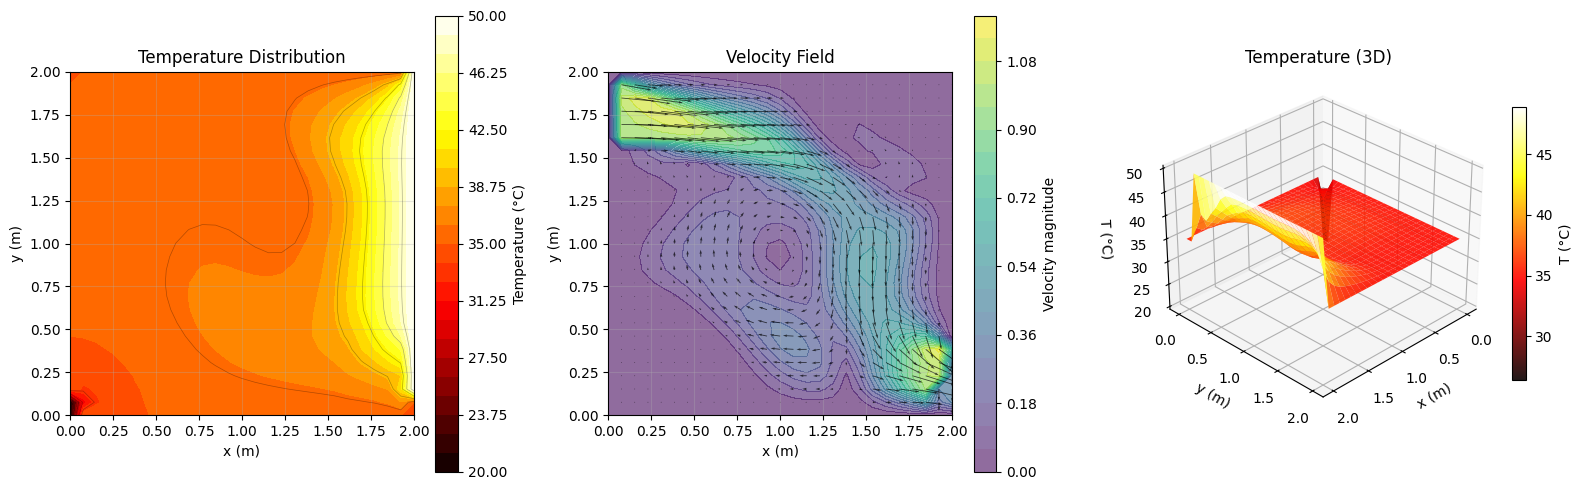


SOLUTION SUMMARY
Temperature range: [20.00, 50.00]°C
Converged in 400 iterations
Energy balance error: 0.000%


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# ============================================================================
# TDMA SOLVER
# ============================================================================
def tdma_solve(a, b, c, d):
    """Thomas algorithm for tridiagonal system"""
    n = len(d)
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)
    x = np.zeros(n)
    
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denom = b[i] - a[i] * c_prime[i-1]
        if abs(denom) < 1e-14:
            denom = 1e-14
        c_prime[i] = c[i] / denom
        d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denom
    
    denom = b[n-1] - a[n-1] * c_prime[n-2]
    if abs(denom) < 1e-14:
        denom = 1e-14
    d_prime[n-1] = (d[n-1] - a[n-1] * d_prime[n-2]) / denom
    
    x[n-1] = d_prime[n-1]
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x


# ============================================================================
# LOAD DATA AND SETUP
# ============================================================================
print("="*70)
print("LOADING DATA FILES")
print("="*70)

xc = np.loadtxt('xc.dat')
yc = np.loadtxt('yc.dat')
u_flat = np.loadtxt('u.dat')
v_flat = np.loadtxt('v.dat')

n = len(u_flat)
nx = int(np.sqrt(n))  # Should be 27
ny = n // nx          # Should be 27

print(f"Grid size: {nx} × {ny} = {n} cells")

# Reshape to 2D arrays (CRITICAL: Fortran order, then transpose)
U = u_flat.reshape((ny, nx), order='F').T
V = v_flat.reshape((ny, nx), order='F').T

# Create grid
x = np.linspace(xc.min(), xc.max(), nx)
y = np.linspace(yc.min(), yc.max(), ny)
dx, dy = x[1] - x[0], y[1] - y[0]

print(f"x range: [{x.min():.4f}, {x.max():.4f}]")
print(f"y range: [{y.min():.4f}, {y.max():.4f}]")
print(f"dx = {dx:.6f}, dy = {dy:.6f}")


# ============================================================================
# PHYSICAL PARAMETERS FROM ASSIGNMENT
# ============================================================================
rho = 1.0                    # Density
Gamma = 1.0 / 50.0          # k/cp = 0.02
L = x.max()                  # Domain length
H = y.max()                  # Domain height
h_A = 0.068 * H             # Inlet A height
h_B = 0.068 * H             # Inlet B height  
h_C = 0.068 * H             # Outlet C height
h_D = x.max()               # Top boundary extent

# Boundary conditions - NOW THESE WILL BE APPLIED!
U_A = 0.0      # Inlet A velocity
U_B = 0.0        # Inlet B velocity (no flow)
U_C = 0.0        # Outlet C velocity
V_D = 0.0        # Top boundary velocity
T_A = 20.0       # Inlet A temperature (°C)
T_wall = 50.0    # Right wall temperature (°C)

print(f"\nPhysical parameters:")
print(f"ρ = {rho}, Γ = {Gamma}")
print(f"Domain: L = {L:.4f}, H = {H:.4f}")
print(f"h_A/H = h_C/H = {h_A/H:.4f}")
print(f"Boundary: T_A = {T_A}°C, T_wall = {T_wall}°C (at x=L, except outlet)")

# U[:6, 22:] = 1.0 # Ua
# V[13:17, 20:] = -1 # Vd
# U[:6, :8] = -1.0 # Ub
# U[20:, :8] = 1.0 # Uc

# ============================================================================
# SOLVER PARAMETERS
# ============================================================================
max_iter = 5000
tolerance = 1e-8
alpha = 0.6  # Under-relaxation factor

OVERRIDE_VELOCITY = True  # Set True to completely ignore loaded velocity

print(f"\nSolver parameters:")
print(f"Max iterations: {max_iter}")
print(f"Tolerance: {tolerance}")
print(f"Under-relaxation: {alpha}")

# ============================================================================
# VELOCITY FIELD - CORRECTED
# ============================================================================
if OVERRIDE_VELOCITY:
    j_hA = int(0.068 * ny)  # Inlet A height (bottom ~2 cells)
    j_hC = int(0.068 * ny)  # Outlet C height
    j_hD = int(0.068 * ny)  # Inlet D height (middle region)
    print(f"\n⚠ OVERRIDING velocity field")
    print(f"Grid: {nx}x{ny}, Inlet/Outlet height: j ≤ {j_hA}")
    
    # Apply boundary conditions with height logic
    for j in range(ny):
        # RIGHT SIDE (i = nx-1 = -1)
        if j <= j_hA:
            U[-1, j] = U_A  # Inlet A (bottom right, horizontal →)
            U[-2, j] = U_A  # Inlet A (bottom right, horizontal →)
            U[-1, j+1] = U_A  # Inlet A (bottom right, horizontal →)
            U[-2, j+1] = U_A  # Inlet A (bottom right, horizontal →)
        else:
            U[-1, j] = 0.0  # Wall (top right, no flow)
        
        # LEFT SIDE (i = 0)
        if j <= j_hA:
            U[0, j] = -U_B  # Outlet B (bottom left, leftward ←)
        else:
            U[0, j] = U_C   # Outlet C (top left, rightward →)
    
    # Vertical inlet at right side middle - SPAN A REGION
    j_mid = ny // 2
    for j in range(j_mid - j_hD, j_mid + j_hD + 1):  # Span around middle
        if 0 <= j < ny:  # Bounds check
            V[-1, j] = V_D  # V_D (downward ↓)
    
    print(f"✓ Boundaries set:")
    print(f"  Right side (i={nx-1}): U_A for j≤{j_hA}, Wall for j>{j_hA}")
    print(f"  Left side (i=0): U_B for j≤{j_hA}, U_C for j>{j_hA}")
    print(f"  Middle vertical: V_D at ({nx-1}, {j_mid-j_hD} to {j_mid+j_hD})")

else:
    print("\n✓ Using velocity field from data files")

print(f"  Final U range: [{U.min():.4f}, {U.max():.4f}]")
print(f"  Final V range: [{V.min():.4f}, {V.max():.4f}]")


# ============================================================================
# INITIALIZE TEMPERATURE
# ============================================================================
T = np.ones((nx, ny)) * 35.0  # Initial guess midway between boundaries

# Apply boundary conditions
for j in range(ny):
    if y[j] <= h_A:
        T[0, j] = T_A  # Inlet A
    
    if y[j] > h_C:
        T[-1, j] = T_wall  # Right wall at x=L (except outlet)

print(f"\nInitial T range: [{T.min():.2f}, {T.max():.2f}]°C")


# ============================================================================
# LINE-BY-LINE TDMA SOLVER
# ============================================================================
print("\n" + "="*70)
print("STARTING ALTERNATING LINE-BY-LINE TDMA SOLVER")
print("="*70)

for iteration in range(max_iter):
    T_old = T.copy()
    
    # ========================================================================
    # X-DIRECTION SWEEP
    # ========================================================================
    for j in range(1, ny-1):
        a = np.zeros(nx)
        b = np.zeros(nx)
        c = np.zeros(nx)
        d = np.zeros(nx)
        
        for i in range(1, nx-1):
            # Face velocities
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Convective fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusive conductances
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Peclet numbers
            Pe_e = F_e / D_e if abs(D_e) > 1e-12 else 1e10
            Pe_w = F_w / D_w if abs(D_w) > 1e-12 else 1e10
            Pe_n = F_n / D_n if abs(D_n) > 1e-12 else 1e10
            Pe_s = F_s / D_s if abs(D_s) > 1e-12 else 1e10
            
            # Hybrid scheme coefficients
            if abs(Pe_e) < 2.0:
                a_E = D_e - 0.5 * F_e
            else:
                a_E = D_e + max(0.0, -F_e)
            
            if abs(Pe_w) < 2.0:
                a_W = D_w + 0.5 * F_w
            else:
                a_W = D_w + max(0.0, F_w)
            
            if abs(Pe_n) < 2.0:
                a_N = D_n - 0.5 * F_n
            else:
                a_N = D_n + max(0.0, -F_n)
            
            if abs(Pe_s) < 2.0:
                a_S = D_s + 0.5 * F_s
            else:
                a_S = D_s + max(0.0, F_s)
            
            # Source term (lagged cross-direction)
            S = a_N * T[i, j+1] + a_S * T[i, j-1]
            
            # Central coefficient
            a_P = a_E + a_W + a_N + a_S
            
            # Assemble tridiagonal system
            a[i] = -a_W
            b[i] = a_P
            c[i] = -a_E
            d[i] = S
        
        # Left boundary (x = 0)
        b[0] = 1.0
        c[0] = 0.0
        if y[j] <= h_A:
            d[0] = T_A  # Inlet A with T_A
        else:
            d[0] = T[0, j]  # Zero gradient (or previous value)
        
        # Right boundary (x = L)
        a[-1] = 0.0
        b[-1] = 1.0
        if y[j] > h_C:
            d[-1] = T_wall  # Fixed wall temperature
        else:
            d[-1] = T[-1, j]  # Outlet C - zero gradient
        
        # Solve tridiagonal system
        T_new = tdma_solve(a, b, c, d)
        T[:, j] = alpha * T_new + (1.0 - alpha) * T[:, j]
    
    # ========================================================================
    # Y-DIRECTION SWEEP
    # ========================================================================
    for i in range(1, nx-1):
        a = np.zeros(ny)
        b = np.zeros(ny)
        c = np.zeros(ny)
        d = np.zeros(ny)
        
        for j in range(1, ny-1):
            # Face velocities
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusion
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Peclet
            Pe_e = F_e / D_e if abs(D_e) > 1e-12 else 1e10
            Pe_w = F_w / D_w if abs(D_w) > 1e-12 else 1e10
            Pe_n = F_n / D_n if abs(D_n) > 1e-12 else 1e10
            Pe_s = F_s / D_s if abs(D_s) > 1e-12 else 1e10
            
            # Hybrid scheme
            if abs(Pe_e) < 2.0:
                a_E = D_e - 0.5 * F_e
            else:
                a_E = D_e + max(0.0, -F_e)
            
            if abs(Pe_w) < 2.0:
                a_W = D_w + 0.5 * F_w
            else:
                a_W = D_w + max(0.0, F_w)
            
            if abs(Pe_n) < 2.0:
                a_N = D_n - 0.5 * F_n
            else:
                a_N = D_n + max(0.0, -F_n)
            
            if abs(Pe_s) < 2.0:
                a_S = D_s + 0.5 * F_s
            else:
                a_S = D_s + max(0.0, F_s)
            
            # Source (lagged)
            S = a_E * T[i+1, j] + a_W * T[i-1, j]
            
            a_P = a_E + a_W + a_N + a_S
            
            # Assemble
            a[j] = -a_S
            b[j] = a_P
            c[j] = -a_N
            d[j] = S
        
        # Bottom boundary (y = 0)
        b[0] = 1.0
        c[0] = 0.0
        d[0] = T[i, 0]
        
        # Top boundary (y = H)
        a[-1] = 0.0
        b[-1] = 1.0
        d[-1] = T[i, -1]
        
        T_new = tdma_solve(a, b, c, d)
        T[i, :] = alpha * T_new + (1.0 - alpha) * T[i, :]
    
    # ========================================================================
    # CONVERGENCE CHECK
    # ========================================================================
    if iteration % 50 == 0:
        residual_sum = 0.0
        cell_count = 0
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u_e = 0.5 * (U[i,j] + U[i+1,j])
                u_w = 0.5 * (U[i,j] + U[i-1,j])
                v_n = 0.5 * (V[i,j] + V[i,j+1])
                v_s = 0.5 * (V[i,j] + V[i,j-1])
                
                F_e = rho * u_e * dy
                F_w = rho * u_w * dy
                F_n = rho * v_n * dx
                F_s = rho * v_s * dx
                
                D_e = Gamma * dy / dx
                D_w = Gamma * dy / dx
                D_n = Gamma * dx / dy
                D_s = Gamma * dx / dy
                
                Pe_e = F_e / D_e if abs(D_e) > 1e-12 else 1e10
                Pe_w = F_w / D_w if abs(D_w) > 1e-12 else 1e10
                Pe_n = F_n / D_n if abs(D_n) > 1e-12 else 1e10
                Pe_s = F_s / D_s if abs(D_s) > 1e-12 else 1e10
                
                if abs(Pe_e) < 2.0:
                    a_E = D_e - 0.5 * F_e
                else:
                    a_E = D_e + max(0.0, -F_e)
                
                if abs(Pe_w) < 2.0:
                    a_W = D_w + 0.5 * F_w
                else:
                    a_W = D_w + max(0.0, F_w)
                
                if abs(Pe_n) < 2.0:
                    a_N = D_n - 0.5 * F_n
                else:
                    a_N = D_n + max(0.0, -F_n)
                
                if abs(Pe_s) < 2.0:
                    a_S = D_s + 0.5 * F_s
                else:
                    a_S = D_s + max(0.0, F_s)
                
                a_P = a_E + a_W + a_N + a_S
                
                residual = abs(a_E * T[i+1, j] + a_W * T[i-1, j] + 
                             a_N * T[i, j+1] + a_S * T[i, j-1] - a_P * T[i, j])
                
                residual_sum += residual
                cell_count += 1
        
        epsilon = residual_sum / cell_count if cell_count > 0 else 0.0
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration:4d}: ε = {epsilon:.6e}, T ∈ [{T.min():.2f}, {T.max():.2f}]°C")
        
        if epsilon < tolerance:
            print(f"\n✓ Converged at iteration {iteration}")
            print(f"  Residual ε = {epsilon:.6e}")
            break

if iteration == max_iter - 1:
    print(f"\n⚠ Reached maximum iterations ({max_iter})")


# ============================================================================
# ENERGY BALANCE
# ============================================================================
print("\n" + "="*70)
print("GLOBAL ENERGY BALANCE")
print("="*70)

flux_in_A = 0
for j in range(ny):
    if y[j] <= h_A:
        flux_in_A += rho * U[0,j] * T[0,j] * dy

flux_out_C = 0
for j in range(ny):
    if y[j] <= h_C:
        flux_out_C += rho * U[-1,j] * T[-1,j] * dy

flux_wall = 0
for j in range(ny):
    if y[j] > h_C:
        dT_dx = (T[-1,j] - T[-2,j]) / dx
        flux_wall += -Gamma * dT_dx * dy

net = flux_in_A - flux_out_C - flux_wall
error_pct = abs(net / flux_in_A) * 100 if abs(flux_in_A) > 1e-10 else 0

print(f"Inlet A flux:   {flux_in_A:12.6e}")
print(f"Outlet C flux:  {flux_out_C:12.6e}")
print(f"Wall flux:      {flux_wall:12.6e}")
print(f"Net imbalance:  {net:12.6e}")
print(f"Error:          {error_pct:.3f}%")


# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("GENERATING PLOTS")
print("="*70)

X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(16, 5))

# Temperature contour
ax1 = fig.add_subplot(131)
levels = np.linspace(T.min(), T.max(), 25)
cf = ax1.contourf(X, Y, T.T, levels=levels, cmap='hot')
plt.colorbar(cf, ax=ax1, label='Temperature (°C)')
ax1.contour(X, Y, T.T, levels=10, colors='black', alpha=0.3, linewidths=0.5)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Temperature Distribution')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Velocity field
ax2 = fig.add_subplot(132)
skip = max(1, nx//15)
vel_mag = np.sqrt(U**2 + V**2)
cf2 = ax2.contourf(X, Y, vel_mag.T, levels=20, cmap='viridis', alpha=0.6)
plt.colorbar(cf2, ax=ax2, label='Velocity magnitude')
ax2.quiver(X[::skip,::skip], Y[::skip,::skip], 
           U.T[::skip,::skip], V.T[::skip,::skip], alpha=0.7)
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_title('Velocity Field')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# 3D surface
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X, Y, T.T, cmap='hot', edgecolor='none', alpha=0.9)
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_zlabel('T (°C)')
ax3.set_title('Temperature (3D)')
ax3.view_init(elev=30, azim=45)
plt.colorbar(surf, ax=ax3, shrink=0.6, label='T (°C)')

plt.tight_layout()
plt.savefig('solution_final.png', dpi=300, bbox_inches='tight')
print("✓ Saved: solution_final.png")
plt.show()

print("\n" + "="*70)
print("SOLUTION SUMMARY")
print("="*70)
print(f"Temperature range: [{T.min():.2f}, {T.max():.2f}]°C")
print(f"Converged in {iteration} iterations")
print(f"Energy balance error: {error_pct:.3f}%")
print("="*70)

In [41]:
y

array([0.        , 0.07692308, 0.15384615, 0.23076923, 0.30769231,
       0.38461538, 0.46153846, 0.53846154, 0.61538462, 0.69230769,
       0.76923077, 0.84615385, 0.92307692, 1.        , 1.07692308,
       1.15384615, 1.23076923, 1.30769231, 1.38461538, 1.46153846,
       1.53846154, 1.61538462, 1.69230769, 1.76923077, 1.84615385,
       1.92307692, 2.        ])